<a href="https://colab.research.google.com/github/AbhijitMishra7/text-to-sql/blob/main/Lora_T5_wikisql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets transformers[sentencepiece]
!pip install sentencepiece
!pip install accelerate
!pip install peft
!pip install evaluate==0.4.0 rouge_score==0.1.2 loralib==0.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=29576b73c1bba153fd96e4d466c068997b55aebc56d3a29c897b46f47daf70c0
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import numpy as np
import pandas as pd
import evaluate
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer, get_linear_schedule_with_warmup
from peft import LoraConfig, get_peft_model, TaskType
from peft import PeftModel, PeftConfig
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [ ]:
from datasets import load_dataset

dataset = load_dataset("wikisql")

Generating test split:   0%|          | 0/15878 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8421 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/56355 [00:00<?, ? examples/s]

In [ ]:
train_data = dataset["train"]
val_data = dataset['validation']
test_data = dataset['test']

print(train_data[0])

{'phase': 1, 'question': 'Tell me what the notes are for South Australia ', 'table': {'header': ['State/territory', 'Text/background colour', 'Format', 'Current slogan', 'Current series', 'Notes'], 'page_title': '', 'page_id': '', 'types': ['text', 'text', 'text', 'text', 'text', 'text'], 'id': '1-1000181-1', 'section_title': '', 'caption': '', 'rows': [['Australian Capital Territory', 'blue/white', 'Yaa·nna', 'ACT · CELEBRATION OF A CENTURY 2013', 'YIL·00A', 'Slogan screenprinted on plate'], ['New South Wales', 'black/yellow', 'aa·nn·aa', 'NEW SOUTH WALES', 'BX·99·HI', 'No slogan on current series'], ['New South Wales', 'black/white', 'aaa·nna', 'NSW', 'CPX·12A', 'Optional white slimline series'], ['Northern Territory', 'ochre/white', 'Ca·nn·aa', 'NT · OUTBACK AUSTRALIA', 'CB·06·ZZ', 'New series began in June 2011'], ['Queensland', 'maroon/white', 'nnn·aaa', 'QUEENSLAND · SUNSHINE STATE', '999·TLG', 'Slogan embossed on plate'], ['South Australia', 'black/white', 'Snnn·aaa', 'SOUTH AUS

In [ ]:
first_example = train_data[0]
print(first_example['question'])
print(first_example['table']['header'])
print(first_example['sql']['human_readable'])

Tell me what the notes are for South Australia 
['State/territory', 'Text/background colour', 'Format', 'Current slogan', 'Current series', 'Notes']
SELECT Notes FROM table WHERE Current slogan = SOUTH AUSTRALIA


In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")

def encode(example,max_source_length = 512,max_target_length = 128):
  question = example['question']
  columns = example['table']['header']
  sql = example['sql']['human_readable']
  task = "Given the columns of the table: {} Create the SQL query for the question: {}".format(columns,question)

  encoder_inputs = tokenizer(task, truncation=True,
                               return_tensors='pt', max_length=max_source_length,
                              pad_to_max_length=True)

  decoder_inputs = tokenizer(sql, truncation=True,
                               return_tensors='pt', max_length=max_target_length,
                              pad_to_max_length=True)

  input_ids = encoder_inputs['input_ids'][0]
  input_attention = encoder_inputs['attention_mask'][0]
  target_ids = decoder_inputs['input_ids'][0]
  target_attention = decoder_inputs['attention_mask'][0]

  outputs = {'input_ids':input_ids, 'attention_mask': input_attention,
               'labels':target_ids, 'decoder_attention_mask':target_attention}
  return outputs


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
'''class TrainDataGenerator(Dataset):
    def __init__(self,data):
        self.features = data[['premise','hypothesis']].values.tolist()
        self.labels=data['label']
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,idx):
        text = self.features[idx]
        encoded_dict = tokenizer.encode_plus(text[0][0],text[0][1], max_length=512,pad_to_max_length = True,truncation=True, add_special_tokens=True,return_attention_mask = True,return_tensors = 'pt')
        padded_token_list = encoded_dict['input_ids'][0]
        token_type_ids = encoded_dict['token_type_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]

        target = torch.tensor(self.labels[idx])

        sample = (padded_token_list, att_mask, token_type_ids, target)

        return sample'''

In [ ]:
train_ds = train_data.map(encode)
val_ds = val_data.map(encode)

Map:   0%|          | 0/56355 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Map:   0%|          | 0/8421 [00:00<?, ? examples/s]

In [ ]:
train_ds.column_names

['phase',
 'question',
 'table',
 'sql',
 'input_ids',
 'attention_mask',
 'labels',
 'decoder_attention_mask']

In [ ]:
columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']
train_ds = train_ds.remove_columns([col for col in train_ds.column_names if col not in columns])
val_ds = val_ds.remove_columns([col for col in val_ds.column_names if col not in columns])

In [ ]:
print(train_ds)
print('Lengths: %d %d %d %d'%(len(train_ds[0]['input_ids']),len(train_ds[0]['attention_mask']),len(train_ds[0]['labels']),len(train_ds[0]['decoder_attention_mask'])))

Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask'],
    num_rows: 56355
})
Lengths: 512 512 128 128


In [ ]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

In [ ]:
original_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16).to(device)

train_ds = train_ds.map(lambda x: {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in x.items()})
val_ds = val_ds.map(lambda x: {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in x.items()})


training_args = TrainingArguments(
    output_dir = './Output',
    learning_rate=1e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=1,
    max_steps=-1
)

trainer = Trainer(
    model=original_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds
)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/56355 [00:00<?, ? examples/s]

Map:   0%|          | 0/8421 [00:00<?, ? examples/s]

In [ ]:
print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%


In [ ]:
trainer.train()

In [ ]:
rouge = evaluate.load('rouge')

def rouge_results(model_summaries,human_baseline_summaries):
  results = rouge.compute(
            predictions=model_summaries,
            references=human_baseline_summaries[0:len(model_summaries)],
            use_aggregator=True,
            use_stemmer=True,
        )
  return results

In [ ]:
instruct_model = trainer.model

In [ ]:
for example in test_data:
  print(example)
  break

{'phase': 1, 'question': "What is terrence ross' nationality", 'table': {'header': ['Player', 'No.', 'Nationality', 'Position', 'Years in Toronto', 'School/Club Team'], 'page_title': 'Toronto Raptors all-time roster', 'page_id': '', 'types': ['text', 'text', 'text', 'text', 'text', 'text'], 'id': '1-10015132-16', 'section_title': 'R', 'caption': 'R', 'rows': [['Aleksandar Radojević', '25', 'Serbia', 'Center', '1999-2000', 'Barton CC (KS)'], ['Shawn Respert', '31', 'United States', 'Guard', '1997-98', 'Michigan State'], ['Quentin Richardson', 'N/A', 'United States', 'Forward', '2013-present', 'DePaul'], ['Alvin Robertson', '7, 21', 'United States', 'Guard', '1995-96', 'Arkansas'], ['Carlos Rogers', '33, 34', 'United States', 'Forward-Center', '1995-98', 'Tennessee State'], ['Roy Rogers', '9', 'United States', 'Forward', '1998', 'Alabama'], ['Jalen Rose', '5', 'United States', 'Guard-Forward', '2003-06', 'Michigan'], ['Terrence Ross', '31', 'United States', 'Guard', '2012-present', 'Wash

In [ ]:
first_example = test_data[0]
print(first_example['question'])
print(first_example['table']['header'])
print(first_example['sql']['human_readable'])

original_model_sql = []

human_baseline_sql = [example['sql']['human_readable'] for example in test_data][0:10]

for i,example in enumerate(test_data):

  if i==10:
    break

  question = example['question']
  columns = example['table']['header']
  task = "Given the columns of the table: {} Create the SQL query for the question: {}".format(columns,question)

  original_model.to(device)

  encoder_inputs = tokenizer(task, truncation=True,
                               return_tensors='pt', max_length=512,
                              pad_to_max_length=True)

  input_ids = encoder_inputs['input_ids'].to(device)
  input_attention = encoder_inputs['attention_mask'].to(device)

  original_model_outputs = original_model.generate(input_ids = input_ids, attention_mask = input_attention)

  original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

  original_model_sql.append(original_model_text_output)

zipped_summaries = list(zip(human_baseline_sql, original_model_sql))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries'])
df

What is terrence ross' nationality
['Player', 'No.', 'Nationality', 'Position', 'Years in Toronto', 'School/Club Team']
SELECT Nationality FROM table WHERE Player = Terrence Ross


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


,human_baseline_summaries,original_model_summaries
0,SELECT Nationality FROM table WHERE Player = T...,Terrence Ross' nationality is United States of...
1,SELECT School/Club Team FROM table WHERE Years...,1995-96 clu was in Toronto
2,SELECT School/Club Team FROM table WHERE Years...,2003-06 school/club team
3,SELECT COUNT School/Club Team FROM table WHERE...,n = 0 school / team n = 0
4,SELECT Round FROM table WHERE Circuit = Assen,Assen_held_in_Assen
5,SELECT COUNT No FROM table WHERE Pole Position...,"No, Race, No, Race Winner, No"
6,SELECT Date FROM table WHERE Circuit = Misano,"No, Race, Round, Circuit, Pole Position, Fast ..."
7,SELECT COUNT Position FROM table WHERE College...,Sherbrooke Faucons (qmjhl) provided a total of
8,SELECT Nationality FROM table WHERE College/ju...,The player picked from Thunder Bay Flyers (ush...
9,SELECT COUNT College/junior/club team FROM tab...,The Washington Capitals NHL Team provided a pl...


In [ ]:
results = rouge_results(df['original_model_summaries'],df['human_baseline_summaries'])
results

{'rouge1': 0.32422094245623656,
 'rouge2': 0.15449494949494946,
 'rougeL': 0.23423636820695642,
 'rougeLsum': 0.23277394990630287}

In [ ]:
'''example = test_data[0]

original_model_sql = []

human_baseline_sql = example['sql']['human_readable']

question = example['question']
columns = example['table']['header']
task = "Given the columns of the table: {} Create the SQL query for the question: {}".format(columns,question)

original_model.to(device)

encoder_inputs = tokenizer(task, truncation=True,
                              return_tensors='pt', max_length=512,
                            pad_to_max_length=True)


input_ids = encoder_inputs['input_ids'].to(device)
input_attention = encoder_inputs['attention_mask'].to(device)

original_model_outputs = original_model.generate(input_ids = input_ids, attention_mask = input_attention)

print(original_model_outputs[0])

original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

original_model_sql.append(original_model_text_output)
'''

tensor([    0, 18925,  3772,     3,  1859,     7,    19,     3,     9,  4151,
          868,     5,     1], device='cuda:0')
Terrence ross is a Canadian National.


In [ ]:
lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)


In [ ]:
peft_model = get_peft_model(original_model,
                            lora_config)
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 3538944
all model parameters: 251116800
percentage of trainable model parameters: 1.41%


In [ ]:
number_of_epochs = 1
learning_rate = 1e-3

In [ ]:
peft_training_args = TrainingArguments(
    output_dir='./Output/peft',
    auto_find_batch_size=True,
    learning_rate=learning_rate, # Higher learning rate than full fine-tuning.
    warmup_ratio = 0.1,
    lr_scheduler_type = 'linear',
    num_train_epochs=number_of_epochs,
    logging_steps=1,
    max_steps=1000
)

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds
)

In [ ]:
peft_trainer.train()

Step,Training Loss
1,53.750000
2,52.250000
3,52.750000
4,52.500000
5,53.000000
6,52.500000
7,51.250000
8,53.500000
9,53.000000
10,56.000000


TrainOutput(global_step=1000, training_loss=2.2745791015625, metrics={'train_runtime': 1272.1851, 'train_samples_per_second': 6.288, 'train_steps_per_second': 0.786, 'total_flos': 5565031907328000.0, 'train_loss': 2.2745791015625, 'epoch': 0.14})

In [ ]:
train_logs = peft_trainer.state.log_history

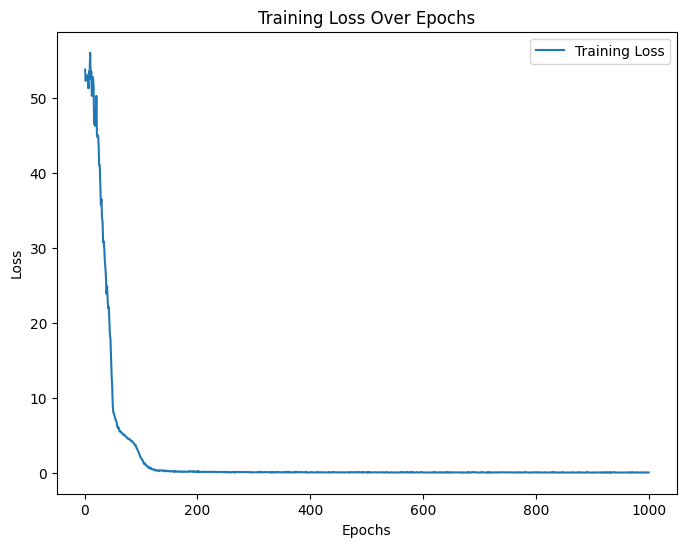

In [ ]:
loss = [l['loss'] for l in train_logs if 'loss' in l]
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, label='Training Loss')

# Adding labels and title
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
lora_model = peft_trainer.model

In [ ]:
table_headers =  [t['header'] for t in test_data['table']][0:10]
table_headers

In [50]:
lora_model_sql = []

human_baseline_sql = [example['sql']['human_readable'] for example in test_data][0:10]

for i,example in enumerate(test_data):

  if i==10:
    break

  question = example['question']
  columns = example['table']['header']
  task = "Given the columns of the table: {} Create the SQL query for the question: {}".format(columns,question)

  lora_model.to(device)

  encoder_inputs = tokenizer(task, truncation=True,
                               return_tensors='pt', max_length=512,
                              pad_to_max_length=True)

  input_ids = encoder_inputs['input_ids'].to(device)
  input_attention = encoder_inputs['attention_mask'].to(device)

  lora_model_outputs = lora_model.generate(input_ids = input_ids, attention_mask = input_attention)

  lora_model_text_output = tokenizer.decode(lora_model_outputs[0], skip_special_tokens=True)

  lora_model_sql.append(lora_model_text_output)

table_headers =  [t['header'] for t in test_data['table']][0:10]

zipped_summaries = list(zip(test_data['question'][0:10],table_headers,human_baseline_sql, lora_model_sql))

df2 = pd.DataFrame(zipped_summaries, columns = ['question', 'column names','human_baseline_summaries', 'lora_model_summaries'])
df2

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


,question,column names,human_baseline_summaries,lora_model_summaries
0,What is terrence ross' nationality,"[Player, No., Nationality, Position, Years in ...",SELECT Nationality FROM table WHERE Player = T...,SELECT Nationality FROM table WHERE Position =...
1,What clu was in toronto 1995-96,"[Player, No., Nationality, Position, Years in ...",SELECT School/Club Team FROM table WHERE Years...,SELECT Clock FROM table WHERE Years in Toronto...
2,which club was in toronto 2003-06,"[Player, No., Nationality, Position, Years in ...",SELECT School/Club Team FROM table WHERE Years...,SELECT Club FROM table WHERE Years in Toronto ...
3,how many schools or teams had jalen rose,"[Player, No., Nationality, Position, Years in ...",SELECT COUNT School/Club Team FROM table WHERE...,SELECT School/Club Team FROM table WHERE No. =...
4,Where was Assen held?,"[No, Date, Round, Circuit, Pole Position, Fast...",SELECT Round FROM table WHERE Circuit = Assen,SELECT ASC No FROM table WHERE Date = assen
5,What was the number of race that Kevin Curtain...,"[No, Date, Round, Circuit, Pole Position, Fast...",SELECT COUNT No FROM table WHERE Pole Position...,SELECT SUM Race winner FROM table WHERE No = k...
6,What was the date of the race in Misano?,"[No, Date, Round, Circuit, Pole Position, Fast...",SELECT Date FROM table WHERE Circuit = Misano,SELECT Date FROM table WHERE Race = misano
7,How many different positions did Sherbrooke Fa...,"[Pick, Player, Position, Nationality, NHL team...",SELECT COUNT Position FROM table WHERE College...,SELECT COUNT Position FROM table WHERE College...
8,What are the nationalities of the player picke...,"[Pick, Player, Position, Nationality, NHL team...",SELECT Nationality FROM table WHERE College/ju...,SELECT Nationality FROM table WHERE NHL team =...
9,How many different college/junior/club teams p...,"[Pick, Player, Position, Nationality, NHL team...",SELECT COUNT College/junior/club team FROM tab...,SELECT COUNT College/junior/club team FROM tab...


In [ ]:
results = rouge_results(df2['lora_model_summaries'],df2['human_baseline_summaries'])
results

{'rouge1': 0.7992196400091137,
 'rouge2': 0.6655348830735828,
 'rougeL': 0.7871723280533349,
 'rougeLsum': 0.7874797418447304}

In [ ]:
peft_trainer.save_model("./lora_t5_trial")